#VENUS nodes

The venus nodes are located in the Georgia Strait. In the grid system set up the East node is at i=283 and j=416 where as the Central node is at i=266 and j=424.


##Plotting the nodes on a map
Here is the location of the nodes.

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import netCDF4 as nc
from dateutil import tz

from salishsea_tools import(viz_tools, tidetools,nc_tools)
from salishsea_tools.nowcast import (analyze, figures)

%matplotlib inline

In [21]:
tracers=nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/01feb15/SalishSea_1d_20150201_20150201_grid_T.nc')
bathya=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

model_depths=tracers.variables['deptht'][:]

bathy=bathya.variables['Bathymetry'][:]
x=bathya.variables['nav_lon'][:]
y=bathya.variables['nav_lat'][:]



The following command loads the most recent data from the VENUS nodes

In [85]:
datas={}; lons={}; lats={}; depths={}
datas['Central'], lons['Central'], lats['Central'], depths['Central']=figures.load_VENUS('Central')
datas['East'], lons['East'], lats['East'], depths['East']=figures.load_VENUS('East')
datas['Central'][['sal','temp']]=datas['Central'][['sal','temp']].astype(float)
datas['East'][['sal','temp']]=datas['East'][['sal','temp']].astype(float)


We can access a nice representation of all the output data in a table by using the following command.

In [87]:
datas['Central'];

Central depth: 300 (m)
East depth: 170 (m)


1.1363636363636362

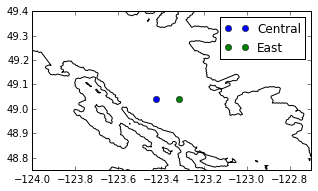

In [24]:
fig, ax=plt.subplots(1,1,figsize=(5,5))
viz_tools.plot_coastline(ax,bathya,coords='map')
for key in ('Central', 'East'):
    ax.plot(lons[key],lats[key],'o',label=key)
    print key, 'depth:', depths[key], '(m)'       
ax.set_xlim([-124, -122.7])
ax.set_ylim([48.75,49.4])
ax.legend(loc='best')
viz_tools.set_aspect(ax)
    

This is where the nodes are located! 

#Comparisons

In [25]:
def truncate(data, t_o,t_f):
    #truncate a data between times t_o and t_f
    sdt=t_o.replace(tzinfo=tz.tzutc()); edt=t_f.replace(tzinfo=tz.tzutc())
    data_trun = data[(data.date< edt) & (data.date >sdt)]
    return data_trun

In [26]:
def compare_model_VENUS(station,start_time, end_time):
    """ function to compare model tmperature and salinity data with 
    VENUS observation over start_time and end_time.
    Station specifies 'East' or 'Central'
    start_time and end_time are datetime objects
    returns mean and standard deviation of model and observations and a figure.
    """
    
    #VENUS observations already loaded. But truncat over plotting tim
    data_trun = truncate(datas[station],start_time,end_time)
    
    #look up grid points that correspond to VENUS nodes
    k = tidetools.find_model_level(depths[station],model_depths)
    [j,i] = tidetools.find_closest_model_point(lons[station],lats[station],x,y,bathy)

    #load model data
    fnames = analyze.get_filenames(start_time,end_time,'1h', 'grid_T','/data/dlatorne/MEOPAR/SalishSea/nowcast/')
    print i,j,k
    sal, time = analyze.combine_files(fnames,'vosaline',k,j,i) 
    temp, time = analyze.combine_files(fnames,'votemper',k,j,i)
    
    #plotting
    #salinity
    fig,axs= plt.subplots(2,1,figsize=(15,10))
    ax=axs[0]
    ax.plot(time,sal,label='model')
    ax.plot(data_trun.date[:],data_trun.sal[:],'-',label='obs')
    ax.set_xlim([start_time,end_time])
    ax.legend(loc=0)
    ax.set_title('Salinity comparison -  VENUS {}'.format(station))
    ax.set_ylabel('Salinty [PSU]')
    #temperature
    ax=axs[1]
    ax.plot(time,temp,label='model')
    ax.plot(data_trun.date[:],data_trun.temp[:],'-',label='obs')
    ax.set_xlim([start_time,end_time])
    ax.legend(loc=0)
    ax.set_title('Temp. comparison - VENUS {}'.format(station))
    ax.set_ylabel('Temperature (deg C)')
    
    #statistics
    means={'sal': {},'temp':{}}; stds={'sal':{},'temp':{}}
    means['sal']['obs']=  data_trun.sal.mean(); stds['sal']['obs']=data_trun.sal.std()
    means['temp']['obs']=  data_trun.temp.mean(); stds['temp']['obs']=data_trun.temp.std()
    means['sal']['model']=  np.mean(sal); stds['sal']['model']=np.std(sal)
    means['temp']['model']=  np.mean(temp); stds['temp']['model']=np.std(temp)
    
    return fig,means,stds

283 416 29
Observed Salinity: Mean 30.4836638889, std 0.333373611687
Modelled Salinity: Mean 30.2985733492, std 0.115469123366
Observed Temperature: Mean 9.23502175926, std 0.20367585987
Modelled Temperature: Mean 9.73158294956, std 0.096555761812


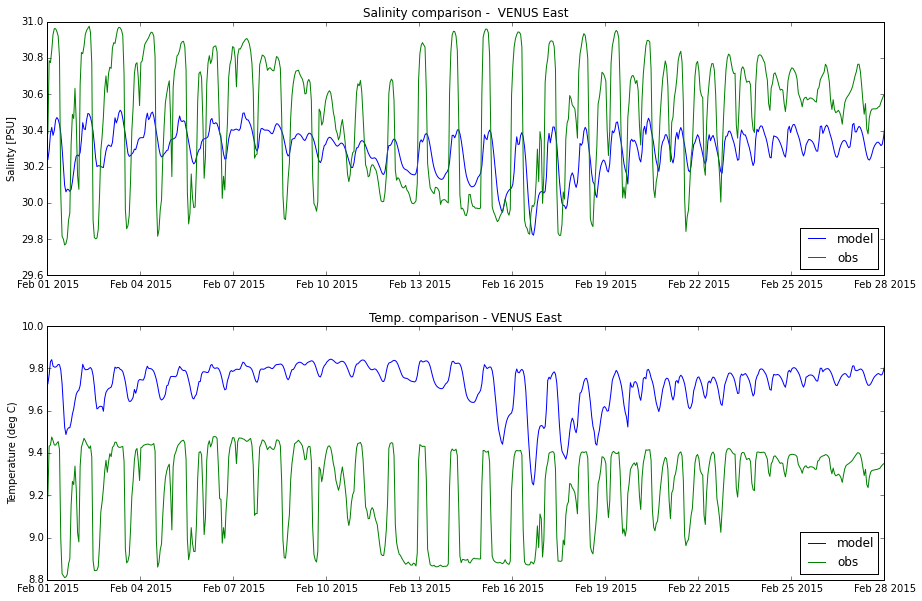

In [27]:
start_time=datetime.datetime(2015,2,1)
end_time=datetime.datetime(2015,2,28)

fig,means,stds=compare_model_VENUS('East',start_time,end_time)

print 'Observed Salinity: Mean {}, std {}'.format(means['sal']['obs'], stds['sal']['obs'])    
print 'Modelled Salinity: Mean {}, std {}'.format(means['sal']['model'], stds['sal']['model'])
    
print 'Observed Temperature: Mean {}, std {}'.format(means['temp']['obs'], stds['temp']['obs'])    
print 'Modelled Temperature: Mean {}, std {}'.format(means['temp']['model'], stds['temp']['model'])

##Model Velocities at VENUS Nodes
First we need to load all the u , v, w data and name the u, v, w velocities as well as the depth (same for u, v and tracers) and the depth of w velocities.

In [40]:
filenameu='/data/dlatorne/MEOPAR/SalishSea/nowcast/07may15/SalishSea_1h_20150507_20150507_grid_U.nc'
filenamev='/data/dlatorne/MEOPAR/SalishSea/nowcast/07may15/SalishSea_1h_20150507_20150507_grid_V.nc'
filenamew='/data/dlatorne/MEOPAR/SalishSea/nowcast/07may15/SalishSea_1h_20150507_20150507_grid_W.nc'

uvel=nc.Dataset(filenameu)
vvel=nc.Dataset(filenamev)
wvel=nc.Dataset(filenamew)


u_u= uvel.variables['vozocrtx']
v_v= vvel.variables['vomecrty']
w_w=wvel.variables['vovecrtz']
dep_t= vvel.variables['depthv']
dep_w=wvel.variables['depthw']

We will be looking at the velocties at the VENUS Central and East nodes. We first need to unstagger the u and v velocities to have them line up with the T grid which is centered in the middle of the cells. After they are centered at the same point we can rotate our axis to have the North and East velocities. This will enable us to compare the model velocities with the VENUS velocities.

In [64]:
def unstag_rot(u_u, v_v, station):
    """ function to unstagger the model velocities to be centered 
    at the tracers cell center. As well as rotate the model velocities
    to be able to compare them with VENUS observations.
    Station specifies 'East' or 'Central'
    u_u and v_v are the zonal and meridonal velocities from the model.
    returns the E/W and N/S velocities as well as the station location 
    model grid for the vertical velocities.
    """
    if station=='Central':
        i=266
        j=424
        depths=330
    else:
        i=283
        j=416
        depths=170

    #We need to access the u velocity that is between i and i-1
    u_t=(u_u[:, :, j, i-1]+u_u[:, :, j, i])/2
    v_t=(v_v[:, :, j, i]+v_v[:, :, j-1, i])/2
    theta=29 
    theta_rad=theta * np.pi /180

    u_E=u_t * np.cos(theta_rad) - v_t * np.sin(theta_rad)
    v_N=u_t * np.sin(theta_rad) + v_t * np.cos(theta_rad)
    return u_E, v_N, i, j, depths

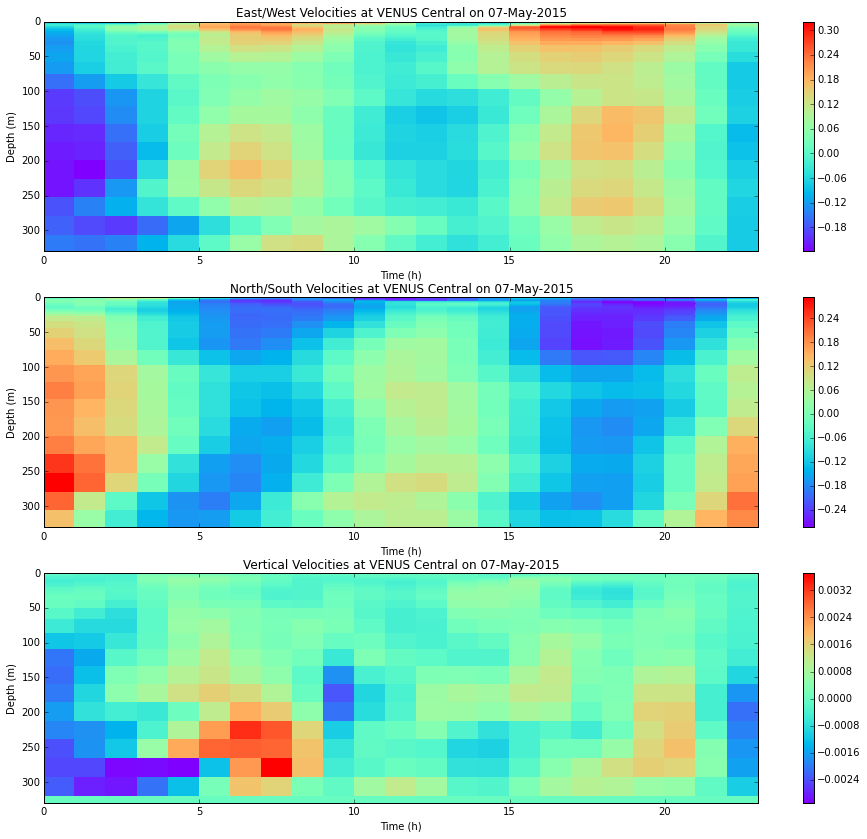

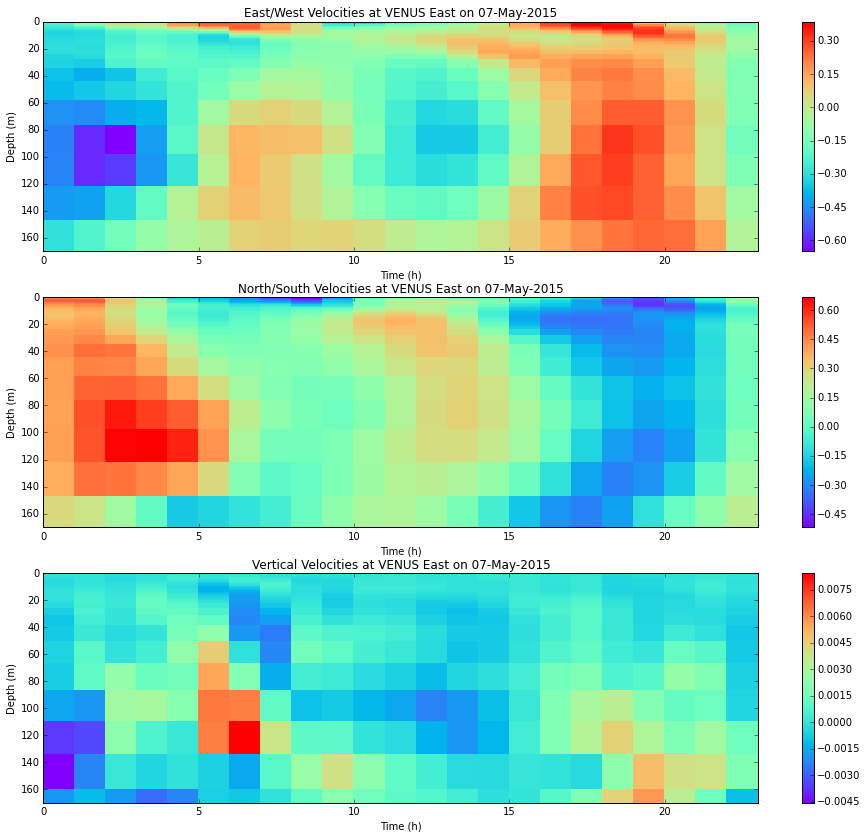

In [67]:
for station in ('Central', 'East'):

    u_E, v_N, i, j, dep_s=unstag_rot(u_u, v_v,station)

    fig, (axu, axv, axw)=plt.subplots(3,1,figsize=(16,14))

    #viz_tools.set_aspect(axu)
    timestamp=nc_tools.timestamp(uvel,1)
    cmap=plt.get_cmap('rainbow')
    axu.invert_yaxis()
    mesh=axu.pcolormesh(np.arange(24),dep_t[:], u_E.transpose(),cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axu)
    axu.set_ylim([dep_s,0])
    axu.set_xlim([0,23])
    axu.set_xlabel('Time (h)')
    axu.set_ylabel('Depth (m)')
    axu.set_title('East/West Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY'))) 

    axv.invert_yaxis()
    mesh=axv.pcolormesh(np.arange(24),dep_t[:], v_N.transpose(),cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axv)
    axv.set_ylim([dep_s,0])
    axv.set_xlim([0,23])
    axv.set_xlabel('Time (h)')
    axv.set_ylabel('Depth (m)')
    axv.set_title('North/South Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY'))) 

    axw.invert_yaxis()
    mesh=axw.pcolormesh(np.arange(24), dep_w[:], w_w[:,:,j,i].transpose(), cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axw)
    axw.set_ylim([dep_s,0])
    axw.set_xlim([0,23])
    axw.set_xlabel('Time (h)')
    axw.set_ylabel('Depth (m)')
    axw.set_title('Vertical Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY'))) 

##VENUS Observational Velocities
Now we will load the VENUS observational velocities.

In [70]:
start_time=nc_tools.timestamp(uvel,0)
end_time=nc_tools.timestamp(uvel,23)

In [74]:
  data_trun = truncate(datas[station],start_time,end_time)

In [78]:
data_trun

,date,pressure,pflag,temp,tflag,sal,sflag,sigmaT,stflag,oxygen,oflag
62960,2015-05-07 01:30:00+00:00,167.1494,7,8.9543,7,30.4839,7,23.5909,7,3.1569,7
62961,2015-05-07 02:30:00+00:00,167.7105,7,9.0275,7,30.2807,7,23.4210,7,3.2351,7
62962,2015-05-07 03:30:00+00:00,168.0306,7,9.0162,7,30.3042,7,23.4399,7,3.2139,7
62963,2015-05-07 04:30:00+00:00,168.0732,7,9.0084,7,30.3178,7,23.4519,7,3.2615,7
62964,2015-05-07 05:30:00+00:00,167.9037,7,8.9208,7,30.5703,7,23.6635,7,3.1718,7
62965,2015-05-07 06:30:00+00:00,167.6229,7,8.9284,7,30.5509,7,23.6470,7,3.1710,7
62966,2015-05-07 07:30:00+00:00,167.2921,7,8.9940,7,30.3705,7,23.4954,7,3.1678,7
62967,2015-05-07 08:30:00+00:00,167.0245,7,9.0146,7,30.3050,7,23.4423,7,3.2029,7
62968,2015-05-07 09:30:00+00:00,166.9150,7,9.0045,7,30.3325,7,23.4650,7,3.2123,7
62969,2015-05-07 10:30:00+00:00,166.9834,7,8.9948,7,30.3646,7,23.4916,7,3.1999,7
